<a href="https://colab.research.google.com/github/Raneemmohamed/1/blob/main/GAT_vs_GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision torchaudio
!pip install torch-scatter torch-sparse torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cu118.html


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATConv, GCNConv
import matplotlib.pyplot as plt

dataset = Planetoid(root='data/Planetoid', name='Cora')
data = dataset[0]


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
Processing...
Done!


In [3]:
class GATNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GATNet, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.6)
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=0.6)
        self.linear = nn.Linear(out_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.gat1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.gat2(x, edge_index)
        x = self.linear(x)
        return x


In [4]:
class GCNNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNNet, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.linear = nn.Linear(out_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.linear(x)
        return x


In [5]:
def train(model, data, optimizer, criterion, epochs=200):
    model.train()
    train_losses = []
    val_accs = []
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            val_acc = evaluate(model, data, mask=data.val_mask)
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}, Validation Accuracy: {val_acc:.4f}')
            val_accs.append(val_acc)
            train_losses.append(loss.item())
    return train_losses, val_accs

def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct = pred[mask] == data.y[mask]
        acc = int(correct.sum()) / int(mask.sum())
    return acc


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

gat_model = GATNet(
    in_channels=dataset.num_node_features,
    hidden_channels=8,
    out_channels=dataset.num_classes
).to(device)

gat_optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.005, weight_decay=5e-4)
gat_criterion = nn.CrossEntropyLoss()

gat_train_losses, gat_val_accs = train(gat_model, data, gat_optimizer, gat_criterion)

gat_test_acc = evaluate(gat_model, data, mask=data.test_mask)
print(f'GAT Test Accuracy: {gat_test_acc:.4f}')


Epoch 10, Loss: 1.5288, Validation Accuracy: 0.7080
Epoch 20, Loss: 0.5667, Validation Accuracy: 0.7660
Epoch 30, Loss: 0.1265, Validation Accuracy: 0.7820
Epoch 40, Loss: 0.0281, Validation Accuracy: 0.7800
Epoch 50, Loss: 0.0092, Validation Accuracy: 0.7840
Epoch 60, Loss: 0.0055, Validation Accuracy: 0.7860
Epoch 70, Loss: 0.0048, Validation Accuracy: 0.7840
Epoch 80, Loss: 0.0050, Validation Accuracy: 0.7820
Epoch 90, Loss: 0.0056, Validation Accuracy: 0.7820
Epoch 100, Loss: 0.0061, Validation Accuracy: 0.7840
Epoch 110, Loss: 0.0063, Validation Accuracy: 0.7840
Epoch 120, Loss: 0.0062, Validation Accuracy: 0.7860
Epoch 130, Loss: 0.0059, Validation Accuracy: 0.7840
Epoch 140, Loss: 0.0057, Validation Accuracy: 0.7860
Epoch 150, Loss: 0.0054, Validation Accuracy: 0.7860
Epoch 160, Loss: 0.0052, Validation Accuracy: 0.7860
Epoch 170, Loss: 0.0050, Validation Accuracy: 0.7860
Epoch 180, Loss: 0.0049, Validation Accuracy: 0.7860
Epoch 190, Loss: 0.0047, Validation Accuracy: 0.7840
Ep

In [7]:
gcn_model = GCNNet(
    in_channels=dataset.num_node_features,
    hidden_channels=16,
    out_channels=dataset.num_classes
).to(device)

gcn_optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01, weight_decay=5e-4)
gcn_criterion = nn.CrossEntropyLoss()

gcn_train_losses, gcn_val_accs = train(gcn_model, data, gcn_optimizer, gcn_criterion)

gcn_test_acc = evaluate(gcn_model, data, mask=data.test_mask)
print(f'GCN Test Accuracy: {gcn_test_acc:.4f}')


Epoch 10, Loss: 1.2710, Validation Accuracy: 0.5860
Epoch 20, Loss: 0.2898, Validation Accuracy: 0.7980
Epoch 30, Loss: 0.0381, Validation Accuracy: 0.7940
Epoch 40, Loss: 0.0086, Validation Accuracy: 0.7820
Epoch 50, Loss: 0.0051, Validation Accuracy: 0.7840
Epoch 60, Loss: 0.0053, Validation Accuracy: 0.7880
Epoch 70, Loss: 0.0067, Validation Accuracy: 0.7960
Epoch 80, Loss: 0.0080, Validation Accuracy: 0.7980
Epoch 90, Loss: 0.0085, Validation Accuracy: 0.7940
Epoch 100, Loss: 0.0084, Validation Accuracy: 0.7900
Epoch 110, Loss: 0.0079, Validation Accuracy: 0.7860
Epoch 120, Loss: 0.0074, Validation Accuracy: 0.7840
Epoch 130, Loss: 0.0070, Validation Accuracy: 0.7840
Epoch 140, Loss: 0.0067, Validation Accuracy: 0.7800
Epoch 150, Loss: 0.0063, Validation Accuracy: 0.7800
Epoch 160, Loss: 0.0060, Validation Accuracy: 0.7800
Epoch 170, Loss: 0.0058, Validation Accuracy: 0.7740
Epoch 180, Loss: 0.0055, Validation Accuracy: 0.7740
Epoch 190, Loss: 0.0053, Validation Accuracy: 0.7760
Ep

GAT Test Accuracy: 0.7870
GCN Test Accuracy: 0.7940
GCN performed better!


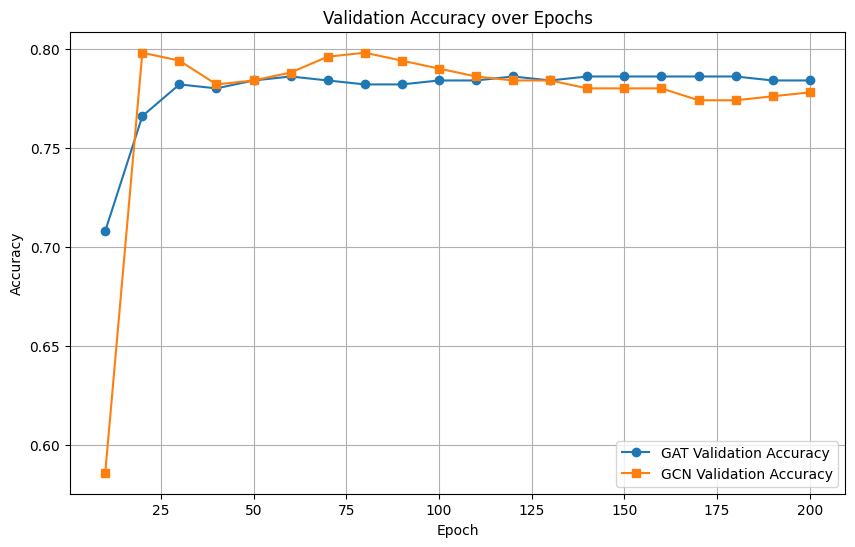

In [8]:
print(f'GAT Test Accuracy: {gat_test_acc:.4f}')
print(f'GCN Test Accuracy: {gcn_test_acc:.4f}')

if gat_test_acc > gcn_test_acc:
    print("GAT performed better!")
else:
    print("GCN performed better!")

plt.figure(figsize=(10,6))
plt.plot(range(10, 201, 10), gat_val_accs, label='GAT Validation Accuracy', marker='o')
plt.plot(range(10, 201, 10), gcn_val_accs, label='GCN Validation Accuracy', marker='s')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Discuss the differences in performance and computational cost between GCN
and GAT. How do the attention mechanism and number of parameters affect the
results?

 Performance Differences

    GAT (Graph Attention Network) usually achieves higher accuracy than GCN (Graph Convolutional Network) on citation datasets like Cora.
    because GAT uses a self-attention mechanism to assign different importance to different neighboring nodes, rather than treating all neighbors equally (like GCN does).
    This enables GAT to focus on more informative or relevant neighbors, leading to better representations.

2. Computational Cost

    GAT is more computationally expensive than GCN.

        In GCN, a simple matrix multiplication and average pooling over neighbors is done.

        In GAT, attention scores are computed pairwise for every node and its neighbors, which involves:

            Extra learnable parameters for attention weights.

            Additional softmax operations and dot products.

    This increases:

        Memory usage (especially with more attention heads).

        Training time (longer epochs).

        Inference time (slower predictions).

3. Effect of Attention Mechanism and Number of Parameters

       it helps GAT dynamically weight neighbors differently, improving node classification, especially on graphs with noisy or heterogeneous edges.

        It avoids "equal influence" assumption in GCN.

        GAT has more parameters because of multiple attention heads and additional projection layers.

        More parameters allow greater model expressiveness, but also require:

            More careful regularization (e.g., dropout).

            More data to prevent overfitting.

        GCN, with fewer parameters, is simpler and faster but may underfit complex datasets.